Problem statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle. 

They have provided multiple attributes around Employee's past and current performance along with demographics. Now, The task is to predict whether a potential promotee at checkpoint in the test set will be promoted or not after the evaluation process.

Load libraries

In [111]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Load and read files

In [112]:
#read files
#Reading train file:
train = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/HR-Analytics/master/train_LZdllcl.csv')
#Reading test file:
test = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/HR-Analytics/master/test_2umaH9m.csv')
#Reading sample submission file:
sample_sub = pd.read_csv('https://raw.githubusercontent.com/TracyRenee61/HR-Analytics/master/sample_submission_M0L0uXE.csv')

In [113]:
train

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54803,3030,Technology,region_14,Bachelor's,m,sourcing,1,48,3.0,17,0,0,78,0
54804,74592,Operations,region_27,Master's & above,f,other,1,37,2.0,6,0,0,56,0
54805,13918,Analytics,region_1,Bachelor's,m,other,1,27,5.0,3,1,0,79,0
54806,13614,Sales & Marketing,region_9,NaN,m,sourcing,1,29,1.0,2,0,0,45,0


In [114]:
train.describe()

,employee_id,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
count,54808.000000,54808.000000,54808.000000,50684.000000,54808.000000,54808.000000,54808.000000,54808.000000,54808.000000
mean,39195.830627,1.253011,34.803915,3.329256,5.865512,0.351974,0.023172,63.386750,0.085170
std,22586.581449,0.609264,7.660169,1.259993,4.265094,0.477590,0.150450,13.371559,0.279137
min,1.000000,1.000000,20.000000,1.000000,1.000000,0.000000,0.000000,39.000000,0.000000
25%,19669.750000,1.000000,29.000000,3.000000,3.000000,0.000000,0.000000,51.000000,0.000000
50%,39225.500000,1.000000,33.000000,3.000000,5.000000,0.000000,0.000000,60.000000,0.000000
75%,58730.500000,1.000000,39.000000,4.000000,7.000000,1.000000,0.000000,76.000000,0.000000
max,78298.000000,10.000000,60.000000,5.000000,37.000000,1.000000,1.000000,99.000000,1.000000


In [115]:
test

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score
0,8724,Technology,region_26,Bachelor's,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelor's,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelor's,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelor's,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelor's,m,sourcing,1,30,4.0,7,0,0,61
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23485,53478,Legal,region_2,Below Secondary,m,sourcing,1,24,3.0,1,0,0,61
23486,25600,Technology,region_25,Bachelor's,m,sourcing,1,31,3.0,7,0,0,74
23487,45409,HR,region_16,Bachelor's,f,sourcing,1,26,4.0,4,0,0,50
23488,1186,Procurement,region_31,Bachelor's,m,sourcing,3,27,NaN,1,0,0,70


Check for null values

In [116]:
train.isnull().sum()

employee_id                0
department                 0
region                     0
education               2409
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    4124
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [117]:
test.isnull().sum()

employee_id                0
department                 0
region                     0
education               1034
gender                     0
recruitment_channel        0
no_of_trainings            0
age                        0
previous_year_rating    1812
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
dtype: int64

Impute missing values

In [118]:
#replace columns with mode
for column in train.columns:
    train[column].fillna(train[column].mode()[0], inplace=True)

for column in test.columns:
    test[column].fillna(test[column].mode()[0], inplace=True)

In [119]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

Label encode objects

In [120]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

train.department = le.fit_transform(train.department)
train.region = le.fit_transform(train.region)
train.education = le.fit_transform(train.education)
train.gender = le.fit_transform(train.gender)
train.recruitment_channel = le.fit_transform(train.recruitment_channel)

test.department = le.fit_transform(test.department)
test.region = le.fit_transform(test.region)
test.education = le.fit_transform(test.education)
test.gender = le.fit_transform(test.gender)
test.recruitment_channel = le.fit_transform(test.recruitment_channel)

Graphically represent target

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


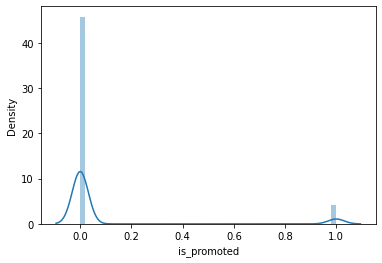

In [121]:
sns.distplot(train['is_promoted'])

Count those promoted

In [122]:
from collections import Counter

print(Counter(train.is_promoted))

Counter({0: 50140, 1: 4668})


Graphically represent data

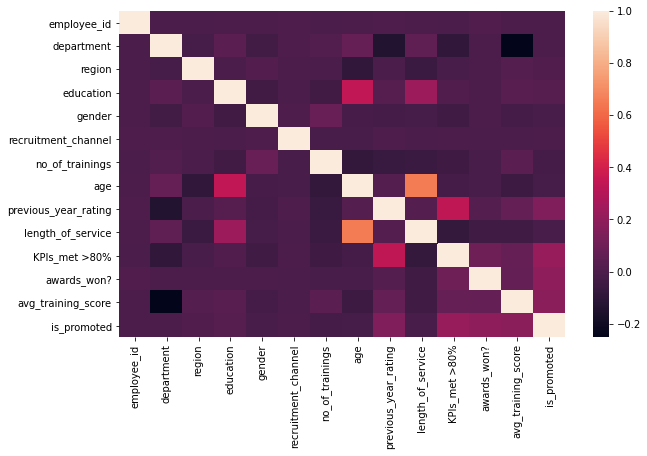

In [123]:
#create a heatmap to correlate promotion
plt.figure(figsize=(10,6))
cmap=train.corr()
sns.heatmap(cmap)

Define X, y and X_test

In [124]:
y = train["is_promoted"]
X = train.drop(['employee_id', 'is_promoted'], axis=1)
X_test = test.drop(['employee_id'], axis=1)

Split training set for training and testing

In [125]:
#split training set for training and testing
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, test_size=0.10, stratify=y, shuffle=True)
#check shapes of testing data
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((49327, 12), (5481, 12), (49327,), (5481,))

Scaler

In [126]:
# Import `StandardScaler` from `sklearn.preprocessing`
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Define the scaler 
scaler = StandardScaler().fit(X_train)
# Scale the train set
X_train = scaler.transform(X_train)
# Scale the validation set
X_val = scaler.transform(X_val)
# Scale the test set
X_test = scaler.transform(X_test)

Class weights

In [127]:
from sklearn.utils import class_weight

class_weights = dict(zip(np.unique(y_train), class_weight.compute_class_weight('balanced',np.unique(y_train), y_train)))

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


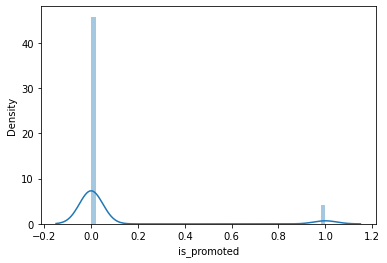

In [128]:
sns.distplot(y_val)

Build model

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting  
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score


models = []
models.append(('RFC',RandomForestClassifier(n_estimators=2000, max_depth=10, random_state=1, class_weight=class_weights)))
models.append(('ADA',AdaBoostClassifier(n_estimators=2000, random_state=1)))
models.append(('LR', LogisticRegression(solver='saga', max_iter=2000,class_weight=class_weights, verbose=1)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier(weights='distance')))
models.append(('DT', DecisionTreeClassifier(class_weight=class_weights)))
models.append(('ET', ExtraTreesClassifier(n_estimators=2000, class_weight=class_weights)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto', kernel='sigmoid', class_weight=class_weights, max_iter=2000)))
models.append(('XGB', XGBClassifier(learning_rate=0.01, n_estimators=2000, max_depth=5, min_child_weight=10, 
                      gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, 
                      objective= 'binary:logistic',scale_pos_weight=3,seed=29, class_weight=class_weights)))
models.append(('HGB', HistGradientBoostingClassifier(loss='binary_crossentrophy', max_iter=2000)))
models.append(('MLP', MLPClassifier(max_iter=2000, random_state=1)))

# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

RFC: 0.718917 (0.007038)
ADA: 0.925680 (0.003105)
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
convergence after 19 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
convergence after 10 ep

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 10 epochs took 0 seconds
convergence after 6 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 12 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 1 seconds
convergence after 16 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 6 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 15 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 15 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 0 seconds
convergence after 12 epochs took 0 seconds
convergence after 11 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 16 epochs took 0 seconds
convergence after 13 epochs took 0 seconds
convergence after 12 epochs took 0 seconds
convergence after 10 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resc

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 14 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 6 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescal

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    4.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
convergence after 15 epochs took 0 seconds
convergence after 15 epochs took 1 seconds
convergence after 11 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
rescaling...
resca

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    3.7s finished


LRCV: 0.724391 (0.007609)
LDA: 0.913475 (0.002055)
KNN: 0.912948 (0.002221)
DT: 0.903907 (0.003049)
ET: 0.929288 (0.002306)
NB: 0.912644 (0.001781)


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_

SVM: 0.591076 (0.062525)
XGB: 0.928802 (0.003806)
HGB: nan (nan)


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Loss binary_crossentrophy is not supported for HistGradientBoostingClassifier. Accepted losses: binary_crossentropy, categorical_crossentropy, auto.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: Loss binary_crossentrophy is not supported for HistGradientBoostingClassifier. Accepted losses: binary_crossentropy, categorical_crossentropy, auto.

  FitFailedWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details

MLP: 0.935188 (0.001693)


Graphically compare models

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1239: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = x[x <= hival]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1246: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = x[x >= loval]
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1254: RuntimeWarning: invalid value encountered in less
  x[x < stats['whislo']],
/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:1255: RuntimeWarning: invalid value encountered in greater
  x[x > stats['whishi']],


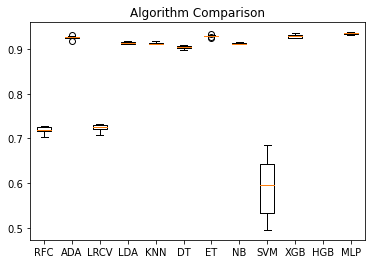

In [130]:
# Compare Algorithms
matplotlib.pyplot.boxplot(results, labels=names)
matplotlib.pyplot.title('Algorithm Comparison')
matplotlib.pyplot.show()

Predict on selected model

In [131]:
# Make predictions on validation dataset
model = XGBClassifier(learning_rate=0.01, n_estimators=2000, max_depth=5, min_child_weight=10, 
                      gamma=0.4,nthread=4, subsample=0.8, colsample_bytree=0.8, 
                      objective= 'binary:logistic',scale_pos_weight=3,seed=29, 
                      class_weight=class_weights).fit(X_train,y_train)
y_pred = model.predict(X_val)
print(model.score(X_val, y_val))

0.9290275497172049


In [132]:
print(Counter(y_pred))

Counter({0: 5123, 1: 358})


In [133]:
from sklearn.metrics import f1_score

print(f1_score(y_val, y_pred))

0.5284848484848484


In [134]:
#Create a confusion matrix
from sklearn.metrics import confusion_matrix

#y_test as first argument and the preds as second argument 
confusion_matrix(y_val, y_pred)

array([[4874,  140],
       [ 249,  218]])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


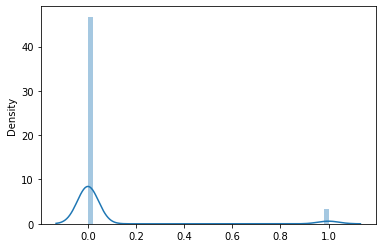

In [135]:
sns.distplot(y_pred)

In [136]:
sample_sub

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0


Predict on test set

In [137]:
prediction = model.predict(X_test)
prediction

array([0, 0, 0, ..., 0, 0, 1])

Prepare submission

In [138]:
output = pd.DataFrame({'employee_id': test.employee_id, 'is_promoted': prediction})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


In [139]:
#upload submission
my_submission = pd.read_csv("my_submission.csv")
my_submission

,employee_id,is_promoted
0,8724,0
1,74430,0
2,72255,0
3,38562,0
4,64486,0
...,...,...
23485,53478,0
23486,25600,0
23487,45409,0
23488,1186,0
